~~~
Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~
# Quick start with Hugging Face

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/medsiglip/blob/main/notebooks/quick_start_with_hugging_face.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>  
  <td style="text-align: center">
    <a href="https://github.com/google-health/medsiglip/blob/main/notebooks/quick_start_with_hugging_face.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/google/medsiglip-448">
      <img alt="Hugging Face logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on Hugging Face
    </a>
  </td>
</tr></tbody></table>

This Colab notebook provides a basic usage example of the MedSigLIP encoder that generates a machine learning representation of images, known as "embeddings", from medical images of a range of modalities. These embeddings can be used to develop custom machine learning models for medical use-cases with less data and compute compared to traditional model development methods. The model also includes a matched text encoder, enabling tasks involving direct matching of images and text.

Learn more about embeddings and their benefits at [this page](https://developers.google.com/health-ai-developer-foundations/medsiglip).

In [8]:
# @title ## Authenticate with HuggingFace, skip if you have a HF_TOKEN secret

# Authenticate user for HuggingFace if needed. Enter token below if requested.
from huggingface_hub.utils import HfFolder

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

153 445


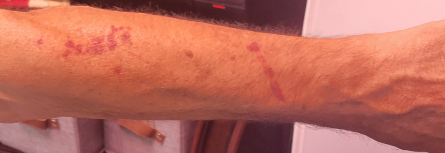

656 576


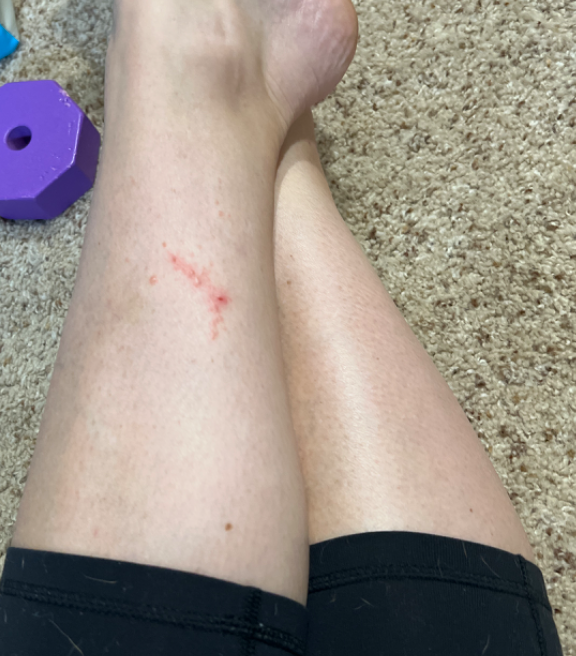

In [9]:
# @title ## Load and display test image from SCIN Dataset
# https://github.com/google-research-datasets/scin

from PIL import Image
from IPython.display import display

# Download sample image
! wget -nc -q https://storage.googleapis.com/dx-scin-public-data/dataset/images/3445096909671059178.png
! wget -nc -q https://storage.googleapis.com/dx-scin-public-data/dataset/images/-5669089898008966381.png

# Load the image, resize, and directly display it
imgs = [Image.open("3445096909671059178.png"), Image.open("-5669089898008966381.png")]
for img in imgs:
    print(img.height, img.width)
    display(img)

In [10]:
# @title ## (Optional) Resize images

# @markdown If you want to reproduce the results from MedSigLIP evals, we
# @markdown recommend a resizing operation with `tf.image.resize` to match the
# @markdown implementation with the Big Vision [library](https://github.com/google-research/big_vision/blob/0127fb6b337ee2a27bf4e54dea79cff176527356/big_vision/pp/ops_image.py#L84).

# @markdown Otherwise, you can rely on the Transformers image processor's
# @markdown built-in resizing (done automatically by default and uses
# @markdown `PIL.Image.resize`) or use another resizing method.

from tensorflow.image import resize as tf_resize
import numpy as np

INPUT_DIMENSION = [448, 448]


def resize(image):
    return Image.fromarray(
        tf_resize(
            images=image, size=INPUT_DIMENSION, method='bilinear', antialias=False
        ).numpy().astype(np.uint8)
    )


imgs = [resize(img) for img in imgs]

In [13]:
# @title ## Run zero-shot classification

from transformers import AutoProcessor, AutoModel
import torch
import numpy as np

zero_shot_model = AutoModel.from_pretrained("google/medsiglip-448")
processor = AutoProcessor.from_pretrained("google/medsiglip-448")

texts = [
    "a photo of an arm with no rash",
    "a photo of an arm with a rash",
    "a photo of a leg with no rash",
    "a photo of a leg with a rash"
]
inputs = processor(text=texts, images=imgs, padding="max_length", return_tensors="pt")

with torch.no_grad():
    outputs = zero_shot_model(**inputs)

bests = np.argmax(outputs.logits_per_image, axis=1)
for index, best in enumerate(bests):
    print(f"The best label for image {index} is '{texts[best]}'")

OSError: We couldn't connect to 'https://huggingface.co' to load the files, and couldn't find them in the cached files.
Check your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

## Obtain Image Embeddings

In [12]:
# @title Prepare model and inputs

from transformers import AutoProcessor, SiglipVisionModel, AutoModel
import torch
import matplotlib.pyplot as plt

model = SiglipVisionModel.from_pretrained("google/medsiglip-448")
processor = AutoProcessor.from_pretrained("google/medsiglip-448")

inputs = processor(images=imgs, padding="max_length", return_tensors="pt")

OSError: We couldn't connect to 'https://huggingface.co' to load the files, and couldn't find them in the cached files.
Check your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [ ]:
# @title Run model

with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
# @title Normalize outputs to embeddings

# This matches the embeddings produced by the SiglipModel class.
output_embeddings = outputs["pooler_output"] / outputs["pooler_output"].norm(p=2, dim=-1, keepdim=True)

In [ ]:
# @title Visualize the embedding vector

print("Size of embedding vector:", output_embeddings.size()[1])
# Plot the embedding vector
plt.figure(figsize=(12, 4))
for vector in output_embeddings.numpy():
    plt.plot(vector)
plt.title('Embedding Vectors')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Next steps

Explore the other [notebooks](https://github.com/google-health/medsiglip/blob/main/notebooks) to learn what else you can do with the model.